In [278]:
#import libraries
from matplotlib import pyplot
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
from keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D
from keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import optimizers
from keras import initializers, regularizers, constraints, callbacks

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from statistics import mean
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import Dense, Input, LSTM,GlobalMaxPool1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  f1_score

In [279]:
##calculating ROC evaluation
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

In [280]:
#import embedding files
EMBEDDING_word2vec= './Embedding_Vecrots/GoogleNews-vectors-negative300.bin'
EMBEDDING_FastText = './Embedding_Vecrots/crawl-300d-2M.vec'
EMBEDDING_GloVe= './Embedding_Vecrots/glove.840B.300d.txt'

#model.save_word2vec_format('path/to/GoogleNews-vectors-negative300.txt', binary=False)

In [281]:
##import train and test data
#train =pd.read_csv('./train.csv')
train =pd.read_excel('./Models/code-review-dataset-full.xlsx')
#test =pd.read_excel('./Models/test.xlsx')

X_train = train["message"].fillna("fillna").values
y_train = train[["is_toxic"]].values
# y_train = train[["toxic"]].Avalues
#X_test = test["message"].fillna("fillna").values

In [282]:
np.count_nonzero(y_train==1)

3752

In [283]:
## set features
#max_features = 30499
max_features =17401
maxlen = 200
embed_size = 300

In [284]:
## some preprocessing
tokenizer = text.Tokenizer(num_words=max_features)
#tokenizer.fit_on_texts(list(X_train) + list(X_test))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
#X_test = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
#x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [285]:
## applying the embedding vector
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')


embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FastText,encoding='utf-8'))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4, inter_op_parallelism_threads=4)
K.set_session(tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf))

In [286]:
#import k-fold
from sklearn.model_selection import KFold
num_folds = 2

run_precision = []
run_recall = []
run_f1score = []
run_accuracy = []


# model
# wrote out all the blocks instead of looping for simplicity
filter_nr = 64
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

In [287]:
from keras.layers import Dense, Input, LSTM,GlobalMaxPool1D
def LSTM_base():
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Fold  1
Train on 15655 samples, validate on 1958 samples
Epoch 1/20
15655/15655 [==============================] - 53s 3ms/step - loss: 0.2635 - accuracy: 0.8970 - val_loss: 0.1368 - val_accuracy: 0.9479
Epoch 2/20
15655/15655 [==============================] - 42s 3ms/step - loss: 0.1070 - accuracy: 0.9607 - val_loss: 0.1125 - val_accuracy: 0.9612
Epoch 3/20
15655/15655 [==============================] - 41s 3ms/step - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.1047 - val_accuracy: 0.9699
Epoch 4/20
15655/15655 [==============================] - 41s 3ms/step - loss: 0.0341 - accuracy: 0.9888 - val_loss: 0.1120 - val_accuracy: 0.9699
Epoch 00004: early stopping
Train: 0.995, Test: 0.970


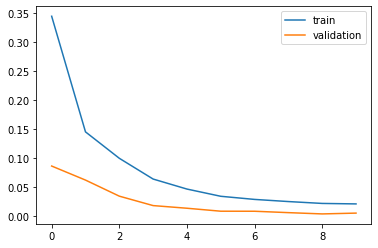

1958/1958 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1478
           1       0.79      0.79      0.79       480

    accuracy                           0.90      1958
   macro avg       0.86      0.86      0.86      1958
weighted avg       0.90      0.90      0.90      1958


Fold  2
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2505 - accuracy: 0.8987 - val_loss: 0.1349 - val_accuracy: 0.9520
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1048 - accuracy: 0.9621 - val_loss: 0.1045 - val_accuracy: 0.9627
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0638 - accuracy: 0.9784 - val_loss: 0.1209 - val_accuracy: 0.9627
Epoch 00003: early stopping
Train: 0.989, Test: 0.963


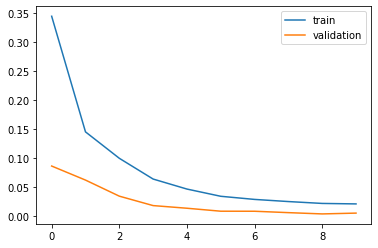

1957/1957 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1640
           1       0.85      0.64      0.73       317

    accuracy                           0.92      1957
   macro avg       0.89      0.81      0.84      1957
weighted avg       0.92      0.92      0.92      1957


Fold  3
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2505 - accuracy: 0.8981 - val_loss: 0.1316 - val_accuracy: 0.9535
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1002 - accuracy: 0.9636 - val_loss: 0.1005 - val_accuracy: 0.9637
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0543 - accuracy: 0.9817 - val_loss: 0.1011 - val_accuracy: 0.9648
Epoch 00003: early stopping
Train: 0.992, Test: 0.965


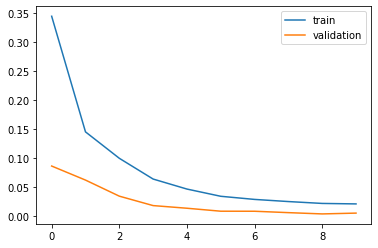

1957/1957 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1583
           1       0.81      0.60      0.69       374

    accuracy                           0.90      1957
   macro avg       0.86      0.79      0.81      1957
weighted avg       0.89      0.90      0.89      1957


Fold  4
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2610 - accuracy: 0.8949 - val_loss: 0.1332 - val_accuracy: 0.9530
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1066 - accuracy: 0.9604 - val_loss: 0.1178 - val_accuracy: 0.9571
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0654 - accuracy: 0.9766 - val_loss: 0.1487 - val_accuracy: 0.9535
Epoch 00003: early stopping
Train: 0.987, Test: 0.954


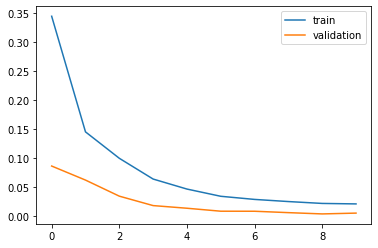

1957/1957 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1214
           1       0.97      0.89      0.93       743

    accuracy                           0.95      1957
   macro avg       0.95      0.94      0.94      1957
weighted avg       0.95      0.95      0.95      1957


Fold  5
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 52s 3ms/step - loss: 0.2585 - accuracy: 0.8924 - val_loss: 0.1455 - val_accuracy: 0.9479
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1169 - accuracy: 0.9520 - val_loss: 0.1299 - val_accuracy: 0.9515
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0732 - accuracy: 0.9730 - val_loss: 0.1316 - val_accuracy: 0.9556
Epoch 00003: early stopping
Train: 0.989, Test: 0.956


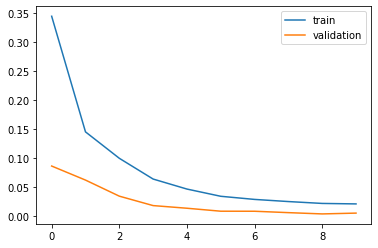

1957/1957 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1557
           1       0.96      0.96      0.96       400

    accuracy                           0.99      1957
   macro avg       0.98      0.98      0.98      1957
weighted avg       0.99      0.99      0.99      1957


Fold  6
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 52s 3ms/step - loss: 0.2825 - accuracy: 0.8826 - val_loss: 0.1445 - val_accuracy: 0.9469
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1203 - accuracy: 0.9535 - val_loss: 0.1328 - val_accuracy: 0.9474
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0724 - accuracy: 0.9748 - val_loss: 0.1347 - val_accuracy: 0.9571
Epoch 00003: early stopping
Train: 0.989, Test: 0.957


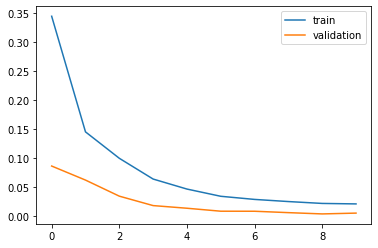

1957/1957 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1756
           1       0.98      0.97      0.98       201

    accuracy                           1.00      1957
   macro avg       0.99      0.98      0.99      1957
weighted avg       1.00      1.00      1.00      1957


Fold  7
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2428 - accuracy: 0.9035 - val_loss: 0.1388 - val_accuracy: 0.9484
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1174 - accuracy: 0.9545 - val_loss: 0.1288 - val_accuracy: 0.9515
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0732 - accuracy: 0.9729 - val_loss: 0.1411 - val_accuracy: 0.9535
Epoch 00003: early stopping
Train: 0.988, Test: 0.954


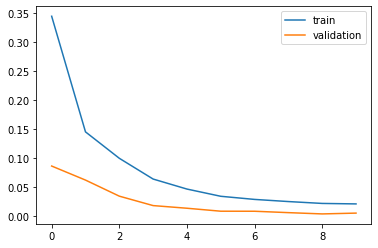

1957/1957 [==============================] - 22s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1585
           1       0.92      0.96      0.94       372

    accuracy                           0.98      1957
   macro avg       0.95      0.97      0.96      1957
weighted avg       0.98      0.98      0.98      1957


Fold  8
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2679 - accuracy: 0.8921 - val_loss: 0.1403 - val_accuracy: 0.9469
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1204 - accuracy: 0.9513 - val_loss: 0.1297 - val_accuracy: 0.9510
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0729 - accuracy: 0.9733 - val_loss: 0.1419 - val_accuracy: 0.9515
Epoch 00003: early stopping
Train: 0.991, Test: 0.951


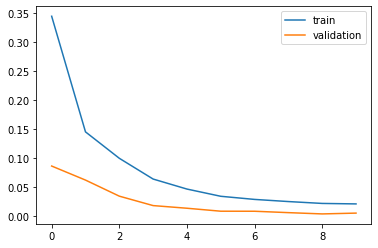

1957/1957 [==============================] - 22s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1434
           1       0.97      0.97      0.97       523

    accuracy                           0.98      1957
   macro avg       0.98      0.98      0.98      1957
weighted avg       0.98      0.98      0.98      1957


Fold  9
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2661 - accuracy: 0.8883 - val_loss: 0.1469 - val_accuracy: 0.9387
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1201 - accuracy: 0.9535 - val_loss: 0.1410 - val_accuracy: 0.9392
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0757 - accuracy: 0.9727 - val_loss: 0.1285 - val_accuracy: 0.9540
Epoch 4/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0463 - accuracy: 0.9845 - val_loss

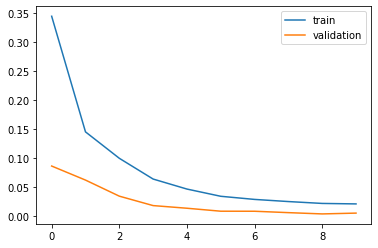

1957/1957 [==============================] - 22s 11ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1669
           1       1.00      0.97      0.98       288

    accuracy                           0.99      1957
   macro avg       1.00      0.98      0.99      1957
weighted avg       0.99      0.99      0.99      1957


Fold  10
Train on 15656 samples, validate on 1958 samples
Epoch 1/20
15656/15656 [==============================] - 53s 3ms/step - loss: 0.2549 - accuracy: 0.8947 - val_loss: 0.1541 - val_accuracy: 0.9459
Epoch 2/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.1206 - accuracy: 0.9534 - val_loss: 0.1328 - val_accuracy: 0.9525
Epoch 3/20
15656/15656 [==============================] - 41s 3ms/step - loss: 0.0741 - accuracy: 0.9735 - val_loss: 0.1428 - val_accuracy: 0.9535
Epoch 00003: early stopping
Train: 0.989, Test: 0.954


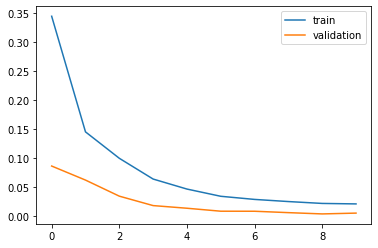

1957/1957 [==============================] - 27s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903
           1       0.95      0.96      0.95        54

    accuracy                           1.00      1957
   macro avg       0.97      0.98      0.98      1957
weighted avg       1.00      1.00      1.00      1957



In [289]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False, random_state=125)
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

count = 1

for train_index, test_index in kf.split(x_train):
    x_trn, x_tst = x_train[train_index], x_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    
    x_new_train, x_val, y_new_train, y_val= train_test_split(x_trn, y_trn, test_size=0.11115, random_state=125)
    
    print("\nFold ", count)
    
    base_LSTM=LSTM_base()
    #es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    h=base_LSTM.fit(x_new_train,  y_new_train, epochs=20, batch_size=64, validation_data=(x_val, y_val), callbacks=[es])
    
    _, train_acc = base_LSTM.evaluate(x_new_train,  y_new_train, verbose=0)
    _, val_acc =  base_LSTM.evaluate(x_val, y_val, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    
    # plot training history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y_pred =base_LSTM.predict(x_tst, batch_size=32, verbose=1)
    y_pred = (y_pred >= 0.5)
 
    
    from sklearn import metrics
    print(metrics.classification_report(y_tst, y_pred))
    
    precision = precision_score(y_tst, y_pred, pos_label=1)
    recall = recall_score(y_tst, y_pred, pos_label=1)
    f1score = f1_score(y_tst, y_pred, pos_label=1)
    accuracy = accuracy_score(y_tst, y_pred)

    run_accuracy.append(accuracy)
    run_f1score.append(f1score)
    run_precision.append(precision)
    run_recall.append(recall)
    
    count = count+1

In [290]:

print(mean(run_precision),mean(run_recall),mean(run_f1score),mean(run_accuracy)) 

0.9202575695626719 0.8715005350021204 0.8926871991124299 0.9598928025061811
